# Domain Randomization of Deep Reinforcement Learning Environments for Zero-Shot Traffic Signal Control

In [1]:
from collections import defaultdict, namedtuple
import itertools
import os
import scipy
import shutil
import sys
from typing import List, Tuple
from tqdm import tqdm
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Colormap
import numpy as np
import pandas as pd
import sumolib

PROJECT_ROOT = os.path.realpath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)
from src.params import * 

For SUMO scripts and demo purposes, please declare environment variable "SUMO_HOME"


In [2]:
class identity_dict(dict):
    def __missing__(self, key):
        return key

## Research Question

**Does domain randomization improve the transferability of deep reinforcement learning-based traffic signal control policies in terms of travel time?**

## Data Preparation

In [90]:
sumocfg_paths = [os.path.join(root, file) for root, _, files in os.walk(TEST_SCENARIOS_ROOT) for file in files if file.endswith(".sumocfg")]
unimpeded_travel_times = defaultdict(lambda: [])
for sumocfg_path in tqdm(sumocfg_paths):
    specific_scenario = "/".join(os.path.normcase(sumocfg_path).split(os.sep)[-2:]).split(".")[0]
    scenario_dir = os.path.join(*os.path.normcase(sumocfg_path).split(os.sep)[:-1])
    net_xml_path = "/" + os.path.join(scenario_dir, ET.parse(sumocfg_path).getroot().find("input").find("net-file").attrib["value"])
    rou_xml_paths = ["/" + os.path.join(scenario_dir, rou_file_name) for rou_file_name in ET.parse(sumocfg_path).getroot().find("input").find("route-files").attrib["value"].split(",")]
    net = sumolib.net.readNet(net_xml_path)
    for rou_xml_path in rou_xml_paths:
        root = ET.parse(rou_xml_path).getroot()
        for trip in [tag for tag in root.iter() if tag.tag == "trip"]:
            vehicle = trip.attrib["id"]
            from_edge = net.getEdge(trip.attrib["from"])
            to_edge = net.getEdge(trip.attrib["to"])
            edges = net.getFastestPath(fromEdge=from_edge, toEdge=to_edge)[0]
            lenghts = np.array([edge.getLength() for edge in edges])
            speeds = np.array([edge.getSpeed() for edge in edges])
            unimpeded_travel_time = np.sum(lenghts / speeds)
            unimpeded_travel_times["specific_scenario"].append(specific_scenario)
            unimpeded_travel_times["vehicle"].append(vehicle)
            unimpeded_travel_times["unimpeded_travel_time"].append(unimpeded_travel_time)
        
        for route in [route for route in root.iter() if route.tag == "vehicle"]:
            vehicle = route.attrib["id"]
            edges = [net.getEdge(edge) for edge in route.find("route").attrib["edges"].split(" ")]
            lenghts = np.array([edge.getLength() for edge in edges])
            speeds = np.array([edge.getSpeed() for edge in edges])
            unimpeded_travel_time = np.sum(lenghts / speeds)
            unimpeded_travel_times["specific_scenario"].append(specific_scenario)
            unimpeded_travel_times["vehicle"].append(vehicle)
            unimpeded_travel_times["unimpeded_travel_time"].append(unimpeded_travel_time)
            
unimpeded_travel_times = pd.DataFrame(unimpeded_travel_times)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 484/484 [00:50<00:00,  9.49it/s]


Read and combine data sets:

In [95]:
vehicle_stats = []
intersection_stats = []
agent_stats = []

include_agents = ["Random", "FixedTime", "MaxPressure", "TransferLight-DQN-arterial-heavy", "TransferLight-DQN-arterial-light", "PressLight-arterial-heavy", "PressLight-arterial-light", "TransferLight-DQN-random-all", "TransferLight-DQN-fixed-all", "TransferLight-A2C-random-all", "TransferLight-A2C-fixed-all"]

jobs = []
print("Load files")
for agent, agents_spec in agent_specs.items():
    if agent not in include_agents:
        continue
    test_dir = os.path.join(agents_spec.agent_dir, "test")
    if not os.path.exists(test_dir):
        continue
    for checkpoint in os.listdir(test_dir):
        checkpoint_dir = os.path.join(test_dir, checkpoint)
        if not os.path.isdir(checkpoint_dir):
            continue
        for scenario in os.listdir(checkpoint_dir):
            scenario_dir = os.path.join(checkpoint_dir, scenario)
            if not os.path.isdir(scenario_dir):
                continue
            for stats_file in os.listdir(scenario_dir):
                stats_file_path = os.path.join(scenario_dir, stats_file)
                if stats_file.endswith("agent.csv") or stats_file.endswith("vehicle.csv") or stats_file.endswith(
                        "intersection.csv"):
                    jobs.append((agent, checkpoint, stats_file_path))
for agent, checkpoint, stats_file_path in tqdm(jobs):
    stats = pd.read_csv(stats_file_path)
    stats["agent"] = agent
    stats["checkpoint"] = checkpoint
    if stats_file_path.endswith("agent.csv"):
        stats = stats[
            ["agent", "checkpoint", "scenario", "intersection", "action_seq", "mc_means_seq", "mc_stds_seq"]]
        agent_stats.append(stats)
    elif stats_file_path.endswith("vehicle.csv"):
        stats = stats[["agent", "checkpoint", "scenario", "vehicle", "departure_time", "arrival_time",
                       "distance_seq", "lane_seq"]]
        vehicle_stats.append(stats)
    else:
        stats = stats[["agent", "checkpoint", "scenario", "intersection", "states", "queue_length_seq", "pressure_seq",
                       "normalized_pressure_seq", "waiting_time_seq"]]
        intersection_stats.append(stats)

dtypes = {"agent": str, "scenario": str, "checkpoint": str}
renaming = {"scenario": "specific_scenario"}
def extract_scenario(df: pd.DataFrame):
    specific_scenarios = df["specific_scenario"]
    return specific_scenarios.apply(lambda x: x.split("/")[0])

print("Combine agent stats")
agent_stats = (
    pd.concat(agent_stats, ignore_index=True, copy=False)
    .rename(columns=renaming)
    .assign(scenario=extract_scenario)
    .astype(dtypes)
)
print("Combine vehicle stats")
vehicle_stats = (
    pd.concat(vehicle_stats, ignore_index=True, copy=False)
    .rename(columns=renaming)
    .assign(scenario=extract_scenario)
    .astype(dtypes.update({"vehicle": str}))
    .merge(unimpeded_travel_times)
    .assign(arrived=lambda x: x["arrival_time"] != -1)
    .assign(travel_time=lambda x: np.where(x["arrived"], x["arrival_time"] - x["departure_time"], np.nan))
    .assign(delay=lambda x: (x["travel_time"] >= x["unimpeded_travel_time"]) * (x["travel_time"] - x["unimpeded_travel_time"]))
)
print("Combine intersection stats")
intersection_stats = (
    pd.concat(intersection_stats, ignore_index=True, copy=False)
    .rename(columns=renaming)
    .assign(scenario=extract_scenario)
    .astype(dtypes)
)

Load files


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14116/14116 [05:31<00:00, 42.54it/s]


Combine agent stats


KeyError: "Only a column name can be used for the key in a dtype mappings argument. 'vehicle' not found in columns."

In [59]:
trainable_agents = sorted([agent for agent, agent_spec in agent_specs.items() if agent_spec.scenario_name is not None])
transferlight_agents = sorted([agent for agent in agent_specs.keys() if agent.startswith("TransferLight")])
transferlight_dqn_agents = ["TransferLight-DQN-fixed-all", "TransferLight-DQN-random-location", "TransferLight-DQN-random-network", "TransferLight-DQN-random-rate", "TransferLight-DQN-fixed-location", "TransferLight-DQN-fixed-network", "TransferLight-DQN-fixed-rate", "TransferLight-DQN-random-all"]
transferlight_a2c_agents = ["TransferLight-A2C-fixed-all", "TransferLight-A2C-random-location", "TransferLight-A2C-random-network", "TransferLight-A2C-random-rate", "TransferLight-A2C-fixed-location", "TransferLight-A2C-fixed-network", "TransferLight-A2C-fixed-rate", "TransferLight-A2C-random-all"]

synthetic_scenarios = ["fixed-all", "random-location", "random-network", "random-rate", "fixed-location", "fixed-network", "fixed-rate", "random-all"]

In [102]:
def vehicles_second_based_agg(group: pd.DataFrame):
    scenario = group.scenario.unique()[0]
    duration = scenario_specs[scenario].test_max_time
    group = group.query(f'arrival_time < {duration} & arrival_time != -1')
    arrival_times = group["arrival_time"]
    n_arrived_vehicles = np.sum(np.eye(duration)[arrival_times], axis=0)
    seconds = np.arange(duration)
    return pd.DataFrame({"second": seconds, "n_arrived_vehicles": n_arrived_vehicles})


def agent_group_agg(group: pd.DataFrame) -> pd.DataFrame:
    actions = list(itertools.chain(*[action_seq.split("|") for action_seq in group["action_seq"]]))
    actions = [int(action) for action in actions]
    mc_stds = [
        float(mc_stds.split("/")[action]) if mc_stds != "" else np.nan
        for action, mc_stds in
        zip(actions, list(itertools.chain(*[mc_means_seq.split("|") for mc_means_seq in group["mc_stds_seq"]])))
    ]
    return pd.DataFrame({"uncertainty": [np.mean(mc_stds)]})
    

def vehicle_group_agg(group: pd.DataFrame) -> pd.DataFrame:
    n_veh_per_s = group.groupby("specific_scenario").apply(vehicles_second_based_agg)["n_arrived_vehicles"]
    throughput = n_veh_per_s.mean()
    throughput_std = n_veh_per_s.std()
    throughput_n = n_veh_per_s.size
    travel_time = group["travel_time"].mean()
    travel_time_std = group["travel_time"].std()
    travel_time_n = group["travel_time"].size
    delay = group["delay"].mean()
    delay_std = group["delay"].std()
    delay_n = group["delay"].size
    return pd.DataFrame({"throughput": [throughput], "throughput_std": [throughput_std], "throughput_n": [throughput_n], 
                         "travel_time": [travel_time], "travel_time_std": [travel_time_std], "travel_time_n": [travel_time_n],
                         "delay": [delay], "delay_std": [delay_std], "delay_n": [delay_n]})


def intersection_group_agg(group: pd.DataFrame) -> pd.DataFrame:
    pressures = list(itertools.chain(*[pressure_seq.split("|") for pressure_seq in group["pressure_seq"]]))
    pressures = [int(pressure) for pressure in pressures]
    pressure = np.mean(pressures)
    pressure_std = np.std(pressures)
    pressure_n = len(pressures)
    normalized_pressures = list(itertools.chain(*[pressure_seq.split("|") for pressure_seq in group["normalized_pressure_seq"]]))
    normalized_pressures = [float(pressure) for pressure in normalized_pressures]
    normalized_pressure = np.mean(normalized_pressures)
    normalized_pressure_std = np.std(normalized_pressures)
    normalized_pressure_n = len(normalized_pressures)
    queue_lengths = list(itertools.chain(*[queue_length_seq.split("|") for queue_length_seq in group["queue_length_seq"]]))
    queue_lengths = [int(queue_length) for queue_length in queue_lengths]
    queue_length = np.mean(queue_lengths)
    queue_length_std = np.std(queue_lengths)
    queue_length_n = len(queue_lengths)
    waiting_times = list(itertools.chain(*[waiting_time_seq.split("|") for waiting_time_seq in group["waiting_time_seq"]]))
    waiting_times = [float(waiting_times) for waiting_times in waiting_times]
    waiting_time = np.mean(waiting_times)
    waiting_time_std = np.std(waiting_times)
    waiting_time_n = len(waiting_times)
    df = pd.DataFrame({"pressure": [pressure], "pressure_std": [pressure_std], "pressure_n": [pressure_n], 
                       "normalized_pressure": [normalized_pressure], "normalized_pressure_std": [normalized_pressure_std], 
                       "normalized_pressure_n": [normalized_pressure_n], 
                       "queue_length": [queue_length], "queue_length_std": [queue_length_std], "queue_length_n": [queue_length_n], 
                       "waiting_time": [waiting_time], "waiting_time_std": [waiting_time_std], "waiting_time_n": [waiting_time_n]})
    return df


agent_stats_ = (
    agent_stats
    .groupby(["agent", "checkpoint", "scenario"])
    .apply(agent_group_agg)
    .reset_index(level=-1, drop=True)
    .reset_index()
)

vehicle_stats_ = (
    vehicle_stats
    .groupby(["agent", "checkpoint", "scenario"])
    .apply(vehicle_group_agg)
    .reset_index(level=-1, drop=True)
    .reset_index()
)

intersection_stats_ = (
    intersection_stats
    .groupby(["agent", "checkpoint", "scenario"])
    .apply(intersection_group_agg)
    .reset_index(level=-1, drop=True)
    .reset_index()
)

stats = (
    vehicle_stats_
    .merge(agent_stats_, how="outer")
    .merge(intersection_stats_)
    .assign(reward=lambda x: -x["normalized_pressure"])
    .assign(reward_std = lambda x: x["normalized_pressure_std"])
    .assign(reward_n = lambda x: x["normalized_pressure_n"])
)
train_stats = (
    stats
    .query('checkpoint != "best"')
    .rename(columns={"checkpoint": "train_step"})
    .astype({"train_step": int})
    .assign(train_step=lambda x: x["train_step"]-100)
)
best_stats = (
    stats
    .query('checkpoint == "best"')
    .drop("checkpoint", axis=1)
)

Determine best performing checkpoint w.r.t. test set: 

In [103]:
def determine_best(group: pd.DataFrame, metric="train_step", agg = np.max) -> pd.DataFrame:
    train_steps = list(group.loc[:, "train_step"])
    metrics = list(group.loc[:, metric])
    best_metric = agg(metrics)
    best_train_step = train_steps[np.argmax(metrics)]
    best_checkpoint = str(best_train_step + 100)
    return pd.DataFrame({"checkpoint": [best_checkpoint], metric: [best_metric]})


trainable_best_stats = (
    train_stats
    .query(f'agent in @trainable_agents')
    .groupby(["agent", "scenario"])
    .apply(determine_best)
    .reset_index(level=-1, drop=True)
    .reset_index()
    .sort_values(by="agent")
)

trainable_best_stats

,agent,scenario,checkpoint,train_step
0,PressLight-arterial-heavy,arterial-heavy,2100,2000
1,PressLight-arterial-light,arterial-light,2100,2000
2,TransferLight-A2C-fixed-all,fixed-all,2100,2000
3,TransferLight-A2C-random-all,random-all,2100,2000
4,TransferLight-DQN-arterial-heavy,arterial-heavy,2100,2000
5,TransferLight-DQN-arterial-light,arterial-light,2100,2000
6,TransferLight-DQN-fixed-all,fixed-all,2100,2000
7,TransferLight-DQN-random-all,random-all,2100,2000


Store best performing checkpoint as 'best.pt':

In [104]:
def write_best(df: pd.DataFrame):
    checkpoint_path = os.path.join(agent_specs[df["agent"]].agent_dir, "checkpoints", f"{df.checkpoint}.pt")
    best_checkpoint_path = os.path.join(agent_specs[df["agent"]].agent_dir, "checkpoints", "best.pt")
    shutil.copy(checkpoint_path, best_checkpoint_path)
    return df

_ = trainable_best_stats.apply(write_best, axis=1)

## Experiment

### Experimental Setup
### Simulation environment
- SUMO
#### Training Scenarios (Source domains)
For main experiment: 
- **fixed-all**: all domain ramdomization parameters held constant throughout training (randomness only appears from ...)
- **random-all**: all domain randomization parameters are randomized throughout training

For ablation study: 
- **fixed-network**: all domain randomization parameters are randomized except the road network
- **fixed-location**: all domain randomization parameters are randomized except the departe/destination location of vehicles
- **fixed-rate**: all domain randomization parameters are randomized except the departure rate of vehicles

Each episode a new scenario is sampled from the source domain randomization space

#### Test Scenarios (Target domains)
Synthetic scenarios: 
- **random-all-heavy**: Like random-all but the departure rate is increased by 50 % 
- **random-all-light**: Like random-all but the departure rate is decreased by 50 %
- **arterial-heavy**: As described in PressLight but with 200m lanes (instead of 300m) and a speed restriction of 13.89 m/s (instead of 10 m/s)
- **arterial-light**: "

Real world scenarios (RESCO benchmark):
- **cologne3**: Arterial road in Cologne with 3 intersections
- **cologne8**: General road network in Cologne with 8 intersections
- **ingolstadt7**: Arterial road in Ingolstadt with 7 intersections
- **ingolstadt21**: General road network in Ingolstadt with 21 intersections

### Compared Methods
TransferLight: 
- **TransferLight-DQN-fixed-all**
- **TransferLight-A2C-fixed-all**
- **TransferLight-DQN-random-all**
- **TransferLight-A2C-random-all**

Baselines: 
- **MaxPressure**
- **FixedTime / GreenWave** (GreenWave if applicable, otherwise default)
- **PressLight** (if applicable)

### Impact of domain randomization on training stability


- Agents are trained for 2000 steps
- Every 100th step the performance of the agents is evaluated on a hold out test set of 10 scenarios that were sampled from the same domain randomization space the respective agent is trained on. 

In [63]:
def plot_axes_training_curves(ax: plt.Axes, agent_xs: List[List[int]], agent_ys: List[List[float]], agent_uncertainties: List[List[float]], agent_cs: List[str], agent_labels: List[str], baseline_ys: List[float], baseline_linestyles: List[str], baseline_labels: List[str], title: str):
    for baseline_y, baseline_linestyle, baseline_label in zip(baseline_ys, baseline_linestyles, baseline_labels):
        ax.axhline(baseline_y, label=baseline_label, linestyle=baseline_linestyle, color="grey")
    
    for agent_x, agent_y, agent_uncertainty, agent_c, agent_label in zip(agent_xs, agent_ys, agent_uncertainties, agent_cs, agent_labels):
        ax.fill_between(agent_x, agent_y - agent_uncertainty/2, agent_y + agent_uncertainty/2, color=agent_c, alpha=0.1)
        ax.plot(agent_x, agent_y, label=agent_label, color=agent_c)
    
    ax.set_title(title)
    
    
def plot_training_curves(metric: str, training_stats: pd.DataFrame, best_stats: pd.DataFrame, y_lim: Tuple[float, float] = None): 
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 5))
    ax_agent_assignment = {
        (0, 0): ["TransferLight-DQN-fixed-all", "TransferLight-A2C-fixed-all"],
        (0, 1): ["TransferLight-DQN-random-all", "TransferLight-A2C-random-all"]
    }
    ax_baseline_assignment = {
        (0, 0): ["Random", "MaxPressure"],
        (0, 1): ["Random", "MaxPressure"]
    }
    metric_labels = {
        "travel_time": "Avg. Travel Time (s)",
        "reward": "Avg. Reward",
        "uncertainty": "Uncertainty"
    }
    
    handles, labels = None, None
    for r in range(1):
        for c in range(2):
            ax = axs[c]
            agents = ax_agent_assignment[(r, c)]
            agent_xs, agent_ys, agent_cs, agent_labels, agent_uncertainties = [], [], [], [], []
            scenario = None
            for agent in agents:
                agent_training_stats = training_stats.query(f'agent == "{agent}"').sort_values("train_step")
                scenario = agent_training_stats["scenario"].unique()[0]
                agent_xs.append(agent_training_stats["train_step"])
                agent_ys.append(agent_training_stats[metric])
                agent_uncertainties.append(agent_training_stats[f"{metric}_std"])
                if agent.startswith("TransferLight-DQN"):
                    agent_labels.append("TransferLight-DQN")
                    agent_cs.append("b")
                elif agent.startswith("TransferLight-A2C"):
                    agent_labels.append("TransferLight-A2C")
                    agent_cs.append("r")
                else:
                    agent_labels.append(agent)
            baselines = ax_baseline_assignment[(r, c)]
            baseline_ys, baseline_labels, baseline_linestyles = [], [], []
            if metric != "uncertainty":
                for baseline in baselines:
                    baseline_stats = best_stats.query(f'agent == "{baseline}" & scenario == "{scenario}"')
                    baseline_ys.append(baseline_stats[metric].iat[0])
                    baseline_labels.append(baseline)
                    if baseline == "Random":
                        baseline_linestyles.append("dotted")
                    elif baseline == "MaxPressure":
                        baseline_linestyles.append("dashed")
            plot_axes_training_curves(ax, agent_xs, agent_ys, agent_uncertainties, agent_cs, agent_labels, baseline_ys, baseline_linestyles, baseline_labels, scenario)
            handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.07), fancybox=True, ncol=4)
    plt.ylim(y_lim)
    ax = fig.add_subplot(111, frameon=False)
    ax.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    ax.set_xlabel("Train step", fontsize=12)
    ax.set_ylabel(metric_labels[metric], fontsize=12)
    ax.xaxis.set_label_coords(0.5, -0.075)
    ax.yaxis.set_label_coords(-0.075, 0.5)
    plt.subplots_adjust(wspace=0.05)
                

#### Reward

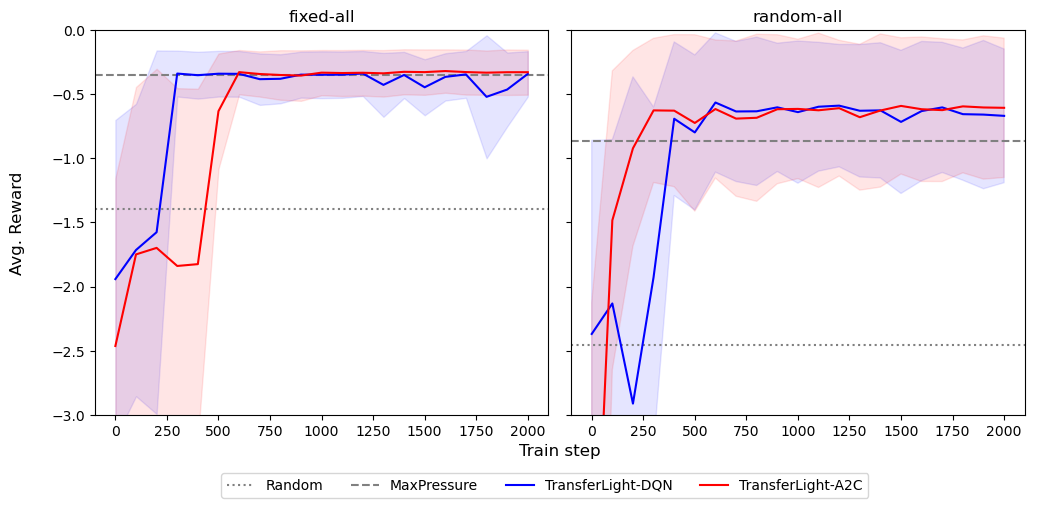

In [64]:
plot_training_curves("reward", train_stats, best_stats, y_lim=(-3.0, 0.0))

- All trained agents converge after about 250-500 training steps. 
- In the fixed-all setting: Both agents reach the same performance level as Max Pressure w.r.t. avg. reward
- In the random-all setting: Both agents outperform Max Pressure w.r.t. avg. reward
- Main insight: Domain randomization does not affect training stability 

### Impact of domain randomization on travel time

In [104]:
def compare_metric_agg(group: pd.DataFrame, metric: str, agents: List[str]):
    res = {}
    for agent in agents:
        res[agent] = group.query(f'agent == "{agent}"')[metric].to_numpy().tolist()
    return pd.DataFrame(res)

test_scenarios = ["random-all-light", "random-all-heavy", "cologne3", "cologne8", "ingolstadt7", "ingolstadt21"]
test_agents = ["FixedTime", "MaxPressure", "TransferLight-DQN-random-all", "TransferLight-DQN-fixed-all", "TransferLight-A2C-random-all", "TransferLight-A2C-fixed-all"]
test_results = (
    best_stats
    .query("scenario in @test_scenarios & agent in @test_agents")
)

travel_time_test_results = (
    test_results
    .groupby("scenario")
    .apply(lambda group: compare_metric_agg(group, "delay", test_agents))
    .reset_index(level=-1, drop=True)
    .reset_index()
)

travel_time_test_results

,scenario,FixedTime,MaxPressure,TransferLight-DQN-random-all,TransferLight-DQN-fixed-all,TransferLight-A2C-random-all,TransferLight-A2C-fixed-all
0,cologne3,41.988633,34.849446,31.077789,32.063371,29.067692,33.569405
1,cologne8,65.551243,48.979574,42.226912,65.798527,32.180499,36.091141
2,ingolstadt21,167.887254,149.327375,147.366661,154.568162,128.444838,151.271448
3,ingolstadt7,82.690967,45.760726,51.216334,59.238392,45.770991,44.559853
4,random-all-heavy,118.718941,95.628579,97.615110,96.161629,87.845466,103.771604
5,random-all-light,70.822741,33.400000,66.450309,57.694782,32.495586,32.681116


In [108]:
def plot_axes_comparison_poxplots(ax: plt.Axes, data: List[List[float]], colors: List, showfliers: bool = True, title: str = "Scenario"):
    bp = ax.boxplot(data, patch_artist=True, showfliers=showfliers)
    for patch, color in zip(bp["boxes"], colors):
        patch.set_facecolor(color)
    if showfliers:
        for flier in bp['fliers']:
            flier.set_alpha(0.1)
    ax.set_title(title)
    ax.grid(axis="y")
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.set_xticks([])
    
    
def plot_travel_time_comparison_boxplots(scenarios: List[str], agents: List[str], vehicle_stats: pd.DataFrame, showfliers: bool = True):
    n_cols = 3
    n_rows = int(np.ceil(len(scenarios) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5))
    ax_scenario_assignment = dict()
    for i, scenario in enumerate(scenarios):
        row = i // 3
        col = i % 3
        ax_scenario_assignment[(row, col)] = scenario
    agent_color_assignment = dict()
    for agent, color in zip(agents, plt.cm.tab10(np.linspace(0, 1, len(agents)))):
        agent_color_assignment[agent] = color
        
    for (r, c) in [(r, c) for r in range(n_rows) for c in range(n_cols)]:
        scenario = ax_scenario_assignment[(r, c)]
        ax = axes[r, c]
        data, colors, medians = [], [], []
        for agent in agents:
            travel_times = vehicle_stats.query(f'agent == "{agent}" & checkpoint == "best" & scenario == "{scenario}" & arrived == True')["delay"].tolist()
            medians.append(np.median(travel_times))
            data.append(travel_times)
            colors.append(agent_color_assignment[agent])
        sort_idx = np.argsort(medians)
        data = [data[idx] for idx in sort_idx]
        colors = [colors[idx] for idx in sort_idx]
        plot_axes_comparison_poxplots(ax, data, colors, showfliers, scenario)
        
    legend_elements = [plt.Rectangle((0, 0), 1, 1, color=color, label=label) for label, color in agent_color_assignment.items()]
    
    ax = fig.add_subplot(111, frameon=False)
    ax.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    ax.set_ylabel("Avg. Travel Time (s)", fontsize=12)
    ax.yaxis.set_label_coords(-0.05, 0.5)
    
    fig.legend(handles=legend_elements, loc="lower center", bbox_to_anchor=(0.5, -0.025), fancybox=True, ncol=len(agents)//2)

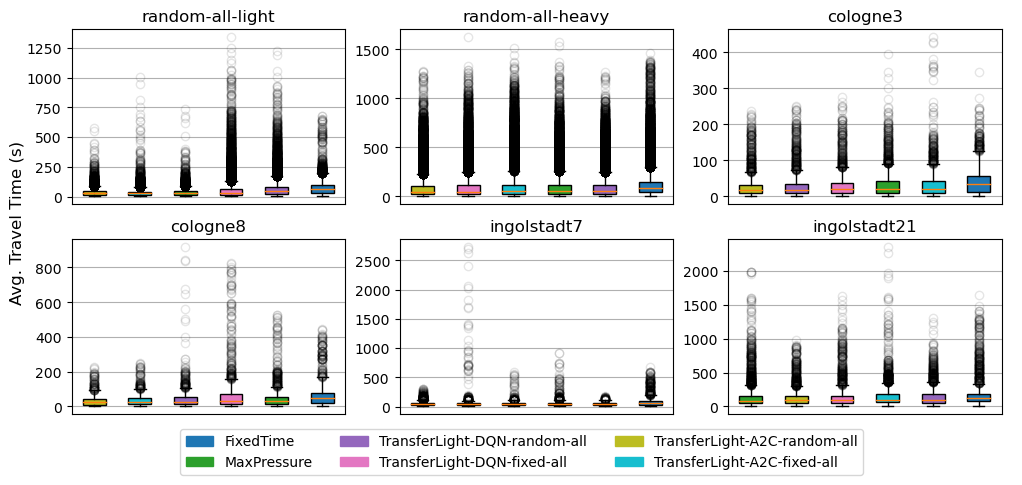

In [ ]:
plot_travel_time_comparison_boxplots(test_scenarios, test_agents, vehicle_stats)

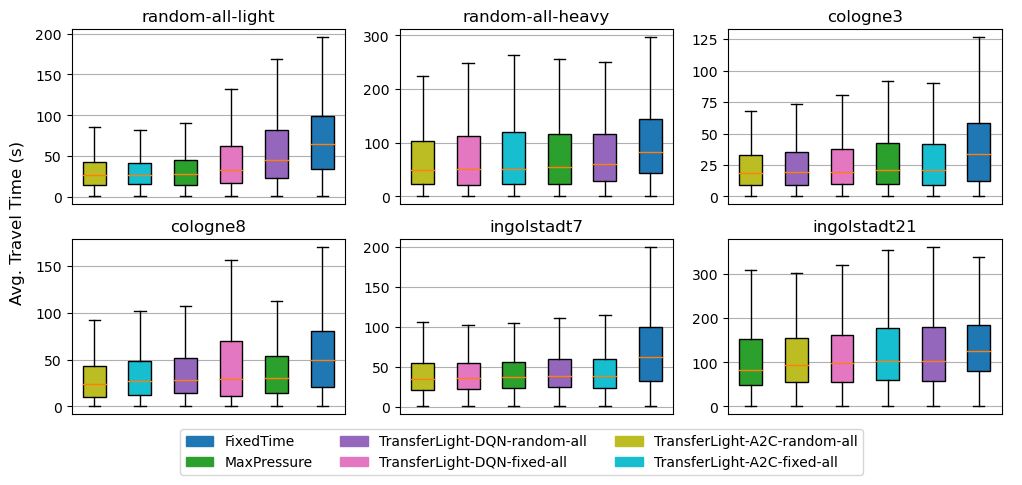

In [110]:
plot_travel_time_comparison_boxplots(test_scenarios, test_agents, vehicle_stats, showfliers=False)

In [112]:
vehicle_stats.query("specific_scenario == 'cologne8/cologne8'").sort_values("delay")

,agent,checkpoint,specific_scenario,vehicle,departure_time,arrival_time,distance_seq,lane_seq,scenario,unimpeded_travel_time,arrived,travel_time,delay
832846,TransferLight-DQN-random-all,best,cologne8/cologne8,236954_451_0,1999,2034,0.0|2.000764519977383|5.742538727028296|11.995...,23283470#0_0|23283470#0_0|23283470#0_0|2328347...,cologne8,35.227111,True,35.0,-0.0
827348,TransferLight-A2C-random-all,best,cologne8/cologne8,181471_431_0,786,848,0.0|2.2905944604892285|6.973222942906433|13.94...,22959550#3_0|22959550#3_0|22959550#3_0|2295955...,cologne8,62.015920,True,62.0,-0.0
833667,TransferLight-DQN-fixed-all,best,cologne8/cologne8,209483_441_0,2292,2315,0.0|2.4712384017184377|7.220006373291834|13.64...,22917421#3_0|22917421#3_0|22917421#3_0|2291742...,cologne8,23.111645,True,23.0,-0.0
833669,MaxPressure,best,cologne8/cologne8,209483_441_0,2292,2315,0.0|2.570238144835457|7.736051455209963|14.696...,22917421#3_0|22917421#3_0|22917421#3_0|2291742...,cologne8,23.111645,True,23.0,-0.0
837130,TransferLight-DQN-random-all,best,cologne8/cologne8,269701_465_0,3411,3477,0.0|1.4626928839366888|5.511605245852844|11.51...,-8716807#4_0|-8716807#4_0|-8716807#4_0|-871680...,cologne8,67.018640,True,66.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
837518,TransferLight-A2C-random-all,best,cologne8/cologne8,272105_466_0,3598,-1,0.0|2.0746073305374013|5.48752433557529|10.922...,-28675510#11_0|-28675510#11_0|-28675510#11_0|-...,cologne8,47.710583,False,NaN,NaN
837519,TransferLight-DQN-fixed-all,best,cologne8/cologne8,272105_466_0,3598,-1,0.0|1.3031529044732455|4.14888565838337|8.6807...,-28675510#11_0|-28675510#11_0|-28675510#11_0|-...,cologne8,47.710583,False,NaN,NaN
837520,TransferLight-DQN-random-all,best,cologne8/cologne8,272105_466_0,3598,-1,0.0|1.8328950374852866|5.658871895424091|11.29...,-28675510#11_0|-28675510#11_0|-28675510#11_0|-...,cologne8,47.710583,False,NaN,NaN
837521,MaxPressure,best,cologne8/cologne8,272105_466_0,3598,-1,0.0|1.976409016130492|6.155545134237037|12.311...,-28675510#11_0|-28675510#11_0|-28675510#11_0|-...,cologne8,47.710583,False,NaN,NaN


In [22]:
def pair_vehicle_stats(agent_x: str, agent_y: str, vehicle_stats: pd.DataFrame) -> pd.DataFrame:
    vehicle_stats_x = (
        vehicle_stats
        .query(f'agent == "{agent_x}"')
    )
    vehicle_stats_y = (
        vehicle_stats
        .query(f'agent == "{agent_y}"')
    )
    return vehicle_stats_x.merge(vehicle_stats_y, on=["scenario", "specific_scenario", "vehicle"])

dqn_paired_vehicle_stats = pair_vehicle_stats("TransferLight-DQN-fixed-all", "TransferLight-DQN-random-all", vehicle_stats.query('checkpoint == "best"'))
a2c_paired_vehicle_stats = pair_vehicle_stats("TransferLight-A2C-fixed-all", "TransferLight-A2C-random-all", vehicle_stats.query('checkpoint == "best"'))

paired_vehicle_stats = (
    pd.concat([dqn_paired_vehicle_stats, a2c_paired_vehicle_stats], axis = 0)
    .assign(travel_time_diff=lambda x: x["travel_time_x"] - x["travel_time_y"])
)

In [23]:
TestResult = namedtuple("PairedTTestResult", ["mean_diff", "std_diff", "t_statistic", "p_value", "n"])

def paired_t_test(paired_differences: np.ndarray, side: str="both"):
    diff = paired_differences  
    n = len(diff)
    mean_diff = np.mean(diff)
    std_diff = np.std(diff)
    se_diff = std_diff / np.sqrt(n)
    t_statistic = mean_diff / se_diff
    df = n-1
    if side == "left":
        p_value = scipy.stats.t.cdf(t_statistic, df)
    elif side == "right":
        p_value = 1 - scipy.stats.t.cdf(t_statistic, df)
    elif side == "both":
        p_value = scipy.stats.t.cdf(- abs(t_statistic), df) * 2
    else:
        raise Exception(f"Invalid side '{side}'")
    return TestResult(mean_diff, std_diff, t_statistic, p_value, n)

(
    paired_vehicle_stats
    .query(f'scenario in @test_scenarios & arrived_x == True & arrived_y == True')
    .groupby(["agent_x", "agent_y", "scenario"])
    .apply(lambda group: pd.DataFrame([scipy.stats.wilcoxon(group["travel_time_diff"], alternative="greater")]))
    .reset_index(level=-1, drop=True)
    .reset_index()
)

,agent_x,agent_y,scenario,statistic,pvalue
0,TransferLight-A2C-fixed-all,TransferLight-A2C-random-all,cologne3,1560810.0,4.950404e-27
1,TransferLight-A2C-fixed-all,TransferLight-A2C-random-all,cologne8,891416.5,2.305573e-23
2,TransferLight-A2C-fixed-all,TransferLight-A2C-random-all,ingolstadt21,3847464.0,8.463559e-35
3,TransferLight-A2C-fixed-all,TransferLight-A2C-random-all,ingolstadt7,1995594.5,3.661156e-42
4,TransferLight-A2C-fixed-all,TransferLight-A2C-random-all,random-all-heavy,934797207.0,0.000000e+00
5,TransferLight-A2C-fixed-all,TransferLight-A2C-random-all,random-all-light,142486224.0,1.848911e-03
6,TransferLight-DQN-fixed-all,TransferLight-DQN-random-all,cologne3,1162169.0,1.575617e-01
7,TransferLight-DQN-fixed-all,TransferLight-DQN-random-all,cologne8,945725.0,1.570366e-12
8,TransferLight-DQN-fixed-all,TransferLight-DQN-random-all,ingolstadt21,1299090.5,7.558028e-03
9,TransferLight-DQN-fixed-all,TransferLight-DQN-random-all,ingolstadt7,1123735.5,9.999969e-01


{'whiskers': [<matplotlib.lines.Line2D at 0x7f9c7c54fe80>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9c7c54f3a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9c7c54e7a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9c7a379ff0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9c7a37ad10>],
 'means': []}

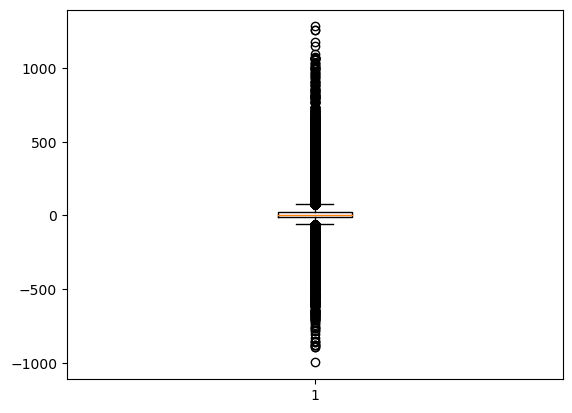

In [92]:
fig, ax = plt.subplots()

df = paired_vehicle_stats.query(f'agent_x == "TransferLight-A2C-fixed-all" & agent_y == "TransferLight-A2C-random-all" & scenario == "random-all-heavy" & arrived_x == True & arrived_y == True')
diff = df["travel_time_diff"]
ax.boxplot(diff.tolist())

### Case study: Learning a green wave

In [38]:
arterial_scenarios = ["arterial-heavy/001", "arterial-light/001"]
arterial_lanes = ["bottom0A0_0", "A0A1_0", "A1A2_0", "A2A3_0", "A3A4_0", "A4top0_0"]
intersection_distances = {
    "A0": 200.0,
    "A1": 400.0,
    "A2": 600.0,
    "A3": 800.0,
    "A4": 1000.0,
    "A5": 1200.0
}
signal_idx = 0
agent_rename = identity_dict()
agent_rename["FixedTime"] = "GreenWave"

intersection_seq_stats = (
    intersection_stats
    .query('specific_scenario in @arterial_scenarios & checkpoint == "best"')
    .assign(distance = lambda x: x["intersection"].apply(lambda x: intersection_distances[x]))
    .assign(states = lambda x: x["states"].apply(lambda y: y.split("|")))
    .assign(time = lambda x: x["states"].apply(lambda x: np.arange(len(x))))
    .explode(["time", "states"])
    .rename(columns={"states": "state"})
    .assign(signal = lambda x: x["state"].apply(lambda x: [*x][signal_idx].lower()))
    .loc[:, ["agent", "checkpoint", "specific_scenario", "scenario", "intersection", "time", "distance", "signal"]]
    .assign(agent = lambda x: x["agent"].apply(lambda x: agent_rename[x]))
)

vehicle_seq_stats = (
    vehicle_stats
    .query('specific_scenario in @arterial_scenarios & checkpoint == "best"')
    .assign(distance_seq = lambda x: x["distance_seq"].apply(lambda x: x.split("|")))
    .assign(lane_seq = lambda x: x["lane_seq"].apply(lambda x: x.split("|")))
    .assign(time = lambda x: x["departure_time"] + x["distance_seq"].apply(lambda x: np.arange(len(x))))
    .explode(["time", "distance_seq", "lane_seq"])
    .rename(columns={"distance_seq": "distance", "lane_seq": "lane"})
    .loc[:, ["agent", "checkpoint", "specific_scenario", "scenario", "vehicle", "time", "distance", "lane"]]
    .query('lane in @arterial_lanes')
    .drop(columns=["lane"])
    .astype({"distance": float})
    .assign(agent = lambda x: x["agent"].apply(lambda x: agent_rename[x]))
)

In [39]:
def plot_axes_time_space_diagram(ax: plt.Axes, intersection_x: List[int], intersection_y: List[float], intersection_c: List[str], vehicle_xs: List[List[int]], vehicle_ys: List[List[float]], title: str = "Agent"):
    ax.scatter(x=intersection_x, y=intersection_y, c=intersection_c, marker="|")
    for vehicle_x, vehicle_y in zip(vehicle_xs, vehicle_ys):
        ax.plot(vehicle_x, vehicle_y, c="k", alpha=0.3)
    ax.set_title(title)
    ax.set_yticks([0] + list(set(intersection_y)))
        
def plot_time_space_diagrams(ax_agent_assignment: Dict[Tuple, str], vehicle_seq_stats: pd.DataFrame, intersection_seq_stats: pd.DataFrame, start_time: int = 600, end_time: int = 800):
    fig, axs = plt.subplots(2, 3, figsize=(12, 5), sharex=True, sharey=True)
    intersection_seq_stats = intersection_seq_stats.query(f'time >= {start_time} & time <= {end_time}')
    vehicle_seq_stats = vehicle_seq_stats.query(f'time >= {start_time} & time <= {end_time}')
    for r in range(2):
        for c in range(3):
            ax = axs[r, c]
            agent = ax_agent_assignment[(r, c)]
            agent_vehicle_seq_stats = vehicle_seq_stats.query(f'agent == "{agent}"')
            agent_intersection_seq_stats = intersection_seq_stats.query(f'agent == "{agent}"')
            intersection_x = agent_intersection_seq_stats["time"]
            intersection_y = agent_intersection_seq_stats["distance"]
            intersection_c = agent_intersection_seq_stats["signal"]
            vehicle_xs = []
            vehicle_ys = []
            for _, group in agent_vehicle_seq_stats.groupby("vehicle"):
                vehicle_xs.append(group["time"])
                vehicle_ys.append(group["distance"])
            plot_axes_time_space_diagram(ax, intersection_x, intersection_y, intersection_c, vehicle_xs, vehicle_ys, title=agent)
            
    ax = fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Distance (m)")
    ax.xaxis.set_label_coords(0.5, -0.13)
    ax.yaxis.set_label_coords(-0.07, 0.5)
    plt.subplots_adjust(wspace=0)

#### arterial-heavy scenario:

In [ ]:
ax_agent_assignment = {
    (0, 0): "GreenWave",
    (0, 1): "PressLight-arterial-heavy",
    (0, 2): "TransferLight-DQN-fixed-all",
    (1, 0): "MaxPressure",
    (1, 1): "TransferLight-DQN-arterial-heavy",
    (1, 2): "TransferLight-DQN-random-all"
}

arterial_heavy_vehicle_seq_stats = vehicle_seq_stats.query('specific_scenario == "arterial-heavy/001"')
arterial_heavy_intersection_seq_stats = intersection_seq_stats.query('specific_scenario == "arterial-heavy/001"')

plot_time_space_diagrams(ax_agent_assignment, arterial_heavy_vehicle_seq_stats, arterial_heavy_intersection_seq_stats)

#### arterial-light scenario:

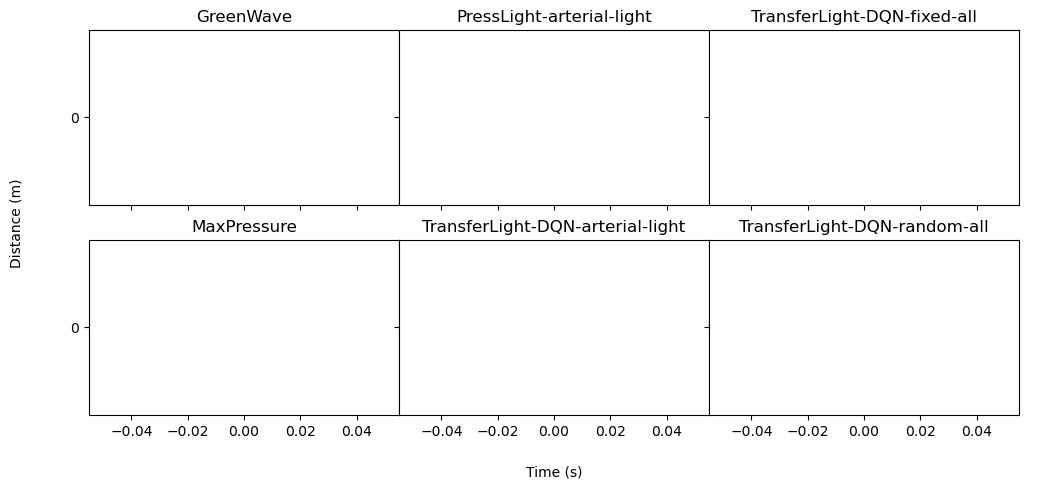

In [42]:
ax_agent_assignment = {
    (0, 0): "GreenWave",
    (0, 1): "PressLight-arterial-light",
    (0, 2): "TransferLight-DQN-fixed-all",
    (1, 0): "MaxPressure",
    (1, 1): "TransferLight-DQN-arterial-light",
    (1, 2): "TransferLight-DQN-random-all"
}

arterial_heavy_vehicle_seq_stats = vehicle_seq_stats.query('specific_scenario == "arterial-light/01"')
arterial_heavy_intersection_seq_stats = intersection_seq_stats.query('specific_scenario == "arterial-light/01"')

plot_time_space_diagrams(ax_agent_assignment, arterial_heavy_vehicle_seq_stats, arterial_heavy_intersection_seq_stats)

### Ablation study: Impact of individual domain variables

## Training Stability

In [5]:
def plot_axes_training_curves(ax: plt.Axes, scenario: str, metric: str, baselines: List[str] = None):
    name_assignment = dict()
    color_assignment = defaultdict(lambda: "grey")
    linestyle_assignment = defaultdict(lambda: "solid")
    for agent in agent_specs.keys():
        if agent.startswith("TransferLight-A2C"):
            name_assignment[agent] = "TransferLight-A2C"
            color_assignment[agent] = "orange"
        elif agent.startswith("TransferLight-DQN"):
            name_assignment[agent] = "TransferLight-DQN"
            color_assignment[agent] = "blue"
        elif agent == "Random":
            linestyle_assignment[agent] = "dotted"
        elif agent == "MaxPressure":
            linestyle_assignment[agent] = "dashed"
            
    baselines = baselines if baselines is not None else []
    for baseline in baselines:
        baseline_stats = best_stats.query(f'agent == "{baseline}" & scenario == "{scenario}"')
        ax.axhline(baseline_stats[metric].iat[0], label=baseline, linestyle=linestyle_assignment[baseline], color=color_assignment[baseline])
    scenario_train_stats = train_stats.query(f'scenario == "{scenario}"').sort_values(by=["agent", "train_step"])
    agents = scenario_train_stats.loc[:, "agent"].sort_values().unique()
    for agent in agents:
        agent_train_stats = scenario_train_stats.query(f"agent == '{agent}'")
        ax.plot(agent_train_stats["train_step"], agent_train_stats[metric], label=name_assignment[agent], color=color_assignment[agent])
    ax.set_title(scenario)


def plot_training_curves(metric: str, baselines: List[str] = None):
    axes_assignment = {
        (0, 0): "fixed-all",
        (0, 1): "random-location",
        (0, 2): "random-rate",
        (0, 3): "random-network",
        (1, 0): "random-all",
        (1, 1): "fixed-location",
        (1, 2): "fixed-rate",
        (1, 3): "fixed-network"
    }
    
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 5), sharex=True, sharey=True)
    
    handles, labels = None, None
    for r in range(2):
        for c in range(4):
            ax = axs[r, c]
            scenario = axes_assignment[(r, c)]
            plot_axes_training_curves(ax, scenario, metric, baselines)
            handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.07), fancybox=True, ncol=4)
    
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel("train step", fontsize=12)
    plt.ylabel(metric, fontsize=12)

### Reward (negative normalized pressure)

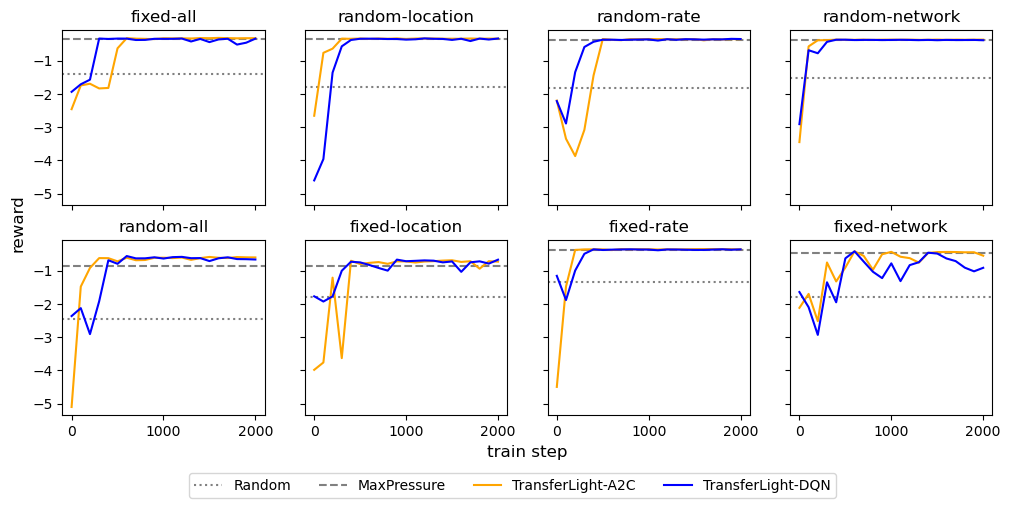

In [6]:
plot_training_curves("reward", baselines=["Random", "MaxPressure"])

### Throughput

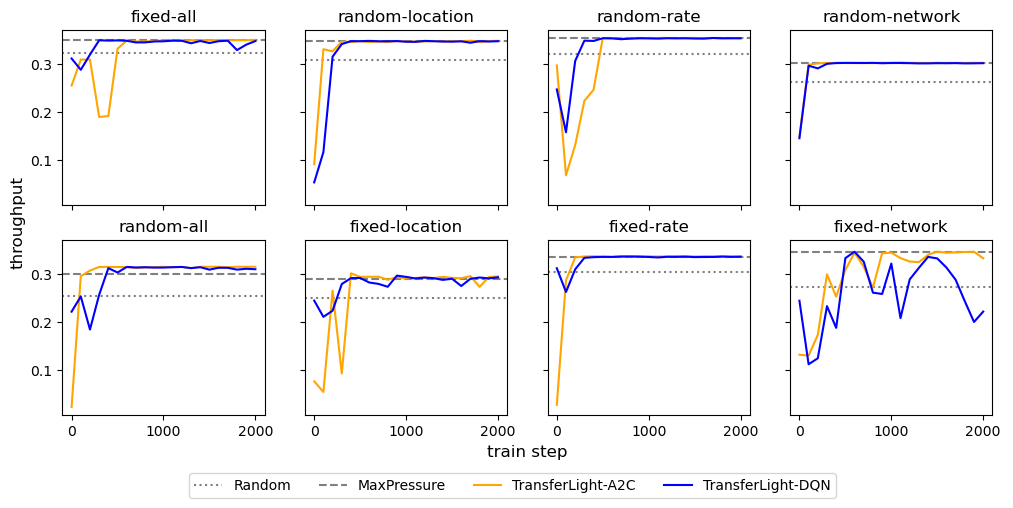

In [7]:
plot_training_curves("throughput", baselines=["Random", "MaxPressure"])

### Travel Time

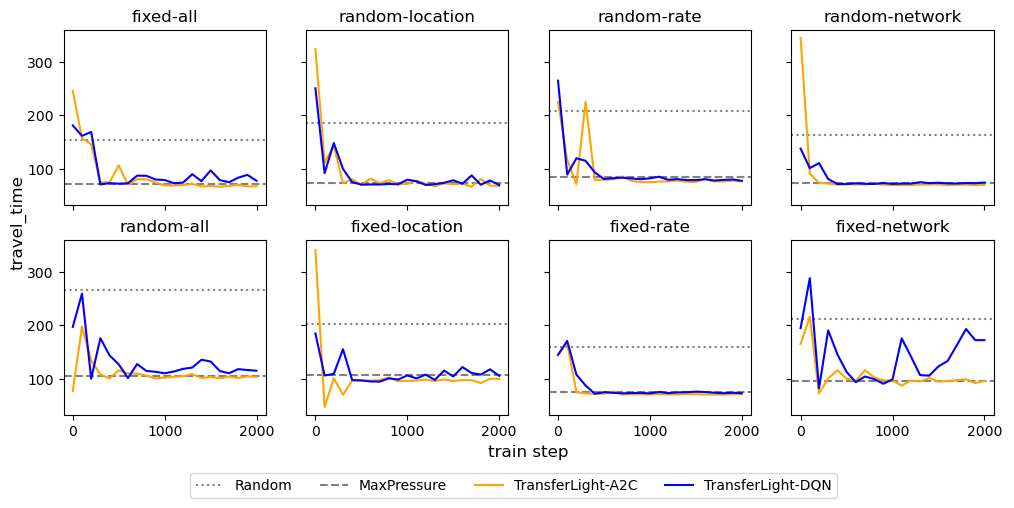

In [8]:
plot_training_curves("travel_time", baselines=["Random", "MaxPressure"])

### Queue Length

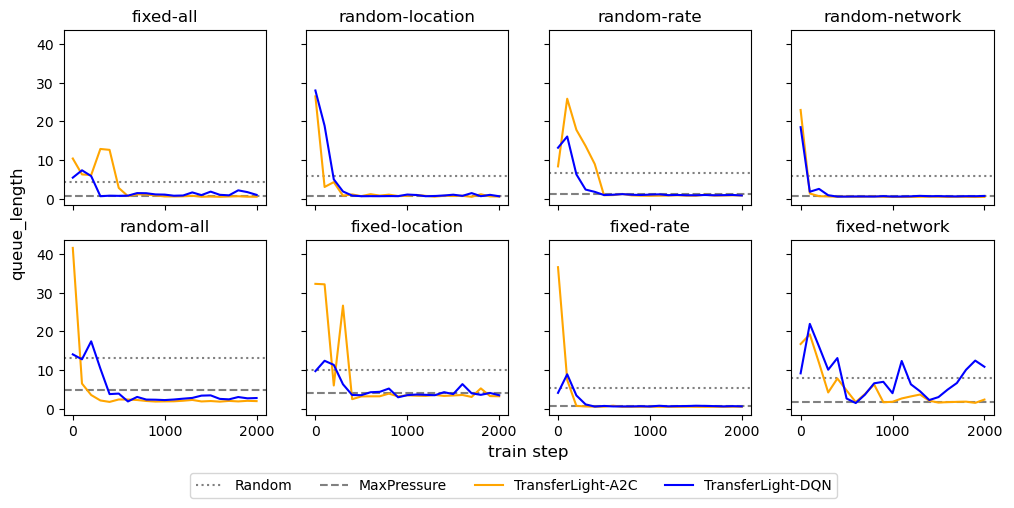

In [9]:
plot_training_curves("queue_length", baselines=["Random", "MaxPressure"])

### Uncertainty

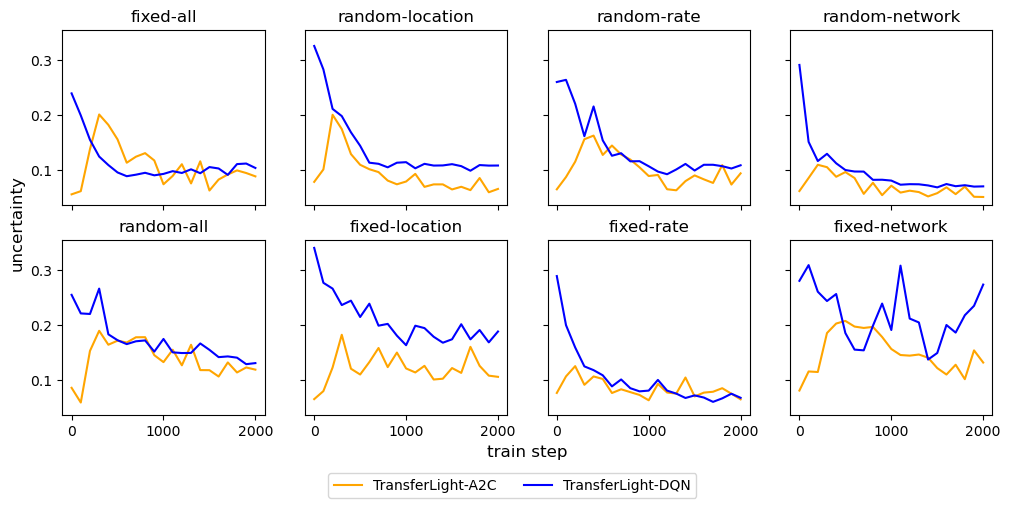

In [10]:
plot_training_curves("uncertainty")

## Extract best performing policy params for each agent

,agent,scenario,checkpoint,throughput
0,PressLight-arterial-heavy,arterial-heavy,1800,1.013167
1,PressLight-arterial-light,arterial-light,1000,0.374500
2,TransferLight-A2C-fixed-all,fixed-all,2100,0.349667
3,TransferLight-A2C-fixed-location,fixed-location,500,0.300944
4,TransferLight-A2C-fixed-network,fixed-network,1600,0.346111
5,TransferLight-A2C-fixed-rate,fixed-rate,1400,0.336444
6,TransferLight-A2C-random-all,random-all,1600,0.314556
7,TransferLight-A2C-random-location,random-location,1800,0.348000
8,TransferLight-A2C-random-network,random-network,1200,0.302333
9,TransferLight-A2C-random-rate,random-rate,1300,0.353889


## Performance Comparison - Paired T-Test

Travel time -> Identical vehicle trips are paired
Throughput -> Identical scenarios are paired

In [1]:
TestResult = namedtuple("PairedTTestResult", ["t_statistic", "p_value", "mean_diff", "std_diff", "n"])


def paired_t_test(observations_population_1: np.ndarray, observations_population_2: np.ndarray):
    diff = observations_population_2 - observations_population_1  
    n = len(diff)
    mean_diff = np.mean(diff)
    std_diff = np.std(diff)
    se_diff = std_diff / np.sqrt(n)
    t_statistic = mean_diff / se_diff
    df = n-1
    p_value = scipy.stats.t.cdf(-abs(t_statistic), df) * 2
    return TestResult(t_statistic, p_value, mean_diff, std_diff, n)


def travel_time_paired_t_test(scenario: str, agent_1: str, agent_2: str):
    vehicle_stats_agent_1 = (
        vehicle_stats
        .query(f'scenario == "{scenario}" & agent == "{agent_1}" & checkpoint == "best" & not travel_time.isnull()')
        .loc[:, ["specific_scenario", "vehicle", "travel_time"]]
        .rename(columns={"travel_time": f"travel_time_agent_1"})
    )
    vehicle_stats_agent_2 = (
        vehicle_stats
        .query(f'scenario == "{scenario}" & agent == "{agent_2}" & checkpoint == "best" & not travel_time.isnull()')
        .loc[:, ["specific_scenario", "vehicle", "travel_time"]]
        .rename(columns={"travel_time": f"travel_time_agent_2"})
    )
    combined_vehicle_stats = (
        vehicle_stats_agent_1
        .merge(vehicle_stats_agent_2, how="inner", on=["specific_scenario", "vehicle"])
    )
    return paired_t_test(combined_vehicle_stats["travel_time_agent_1"], combined_vehicle_stats["travel_time_agent_2"])
    
    
def throughput_paired_t_test(scenario: str, agent_1: str, agent_2: str):
    vehicle_stats_agent_1 = (
        vehicle_stats
        .query(f'scenario == "{scenario}" & agent == "{agent_1}" & checkpoint == "best"')
        .loc[:, ["specific_scenario", "arrived"]]
        .groupby("specific_scenario")
        .agg({"arrived": lambda x: np.sum(x)})
        .reset_index()
        .rename(columns={"arrived": "throughput_agent_1"})
    )
    vehicle_stats_agent_2 = (
        vehicle_stats
        .query(f'scenario == "{scenario}" & agent == "{agent_2}" & checkpoint == "best"')
        .loc[:, ["specific_scenario", "arrived"]]
        .groupby("specific_scenario")
        .agg({"arrived": lambda x: np.sum(x)})
        .reset_index()
        .rename(columns={"arrived": "throughput_agent_2"})
    )
    combined_vehicle_stats = (
        vehicle_stats_agent_1
        .merge(vehicle_stats_agent_2, how="inner", on=["specific_scenario"])
    )
    return paired_t_test(combined_vehicle_stats["throughput_agent_1"], combined_vehicle_stats["throughput_agent_2"])
    
    
def paired_t_test_matrix(metric: str, specialized_agents: List[str], compare_agents: List[str]):
    if metric == "travel_time":
        test = travel_time_paired_t_test
    elif metric == "throughput": 
        test = throughput_paired_t_test
    else:
        raise Exception(f"Metric {metric} not supported")
    
    test_results_matrix = []
    for specialized_agent in specialized_agents:
        test_results_row = []
        scenario = agent_specs[specialized_agent].scenario_name
        for compare_agent in compare_agents:
            if compare_agent == specialized_agent:
                test_results_row.append(None)
            else:
                test_results_row.append(test(scenario, specialized_agent, compare_agent))
        test_results_matrix.append(test_results_row)
    return test_results_matrix

NameError: name 'namedtuple' is not defined

In [103]:
def plot_heatmap(data: np.ndarray, labels: List[List[str]], x_tick_labels: List[str], y_tick_labels: List[str], cmap: Colormap, vmin: int, vmax: int):
    fig, ax = plt.subplots(figsize=(15, 5))
    im = ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto')
    colorbar = ax.figure.colorbar(im, ax=ax)
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks([colorbar.vmin + r / 5 * (0.5 + i) for i in range(5)])
    colorbar.set_ticklabels(["p < 0.01, t < 0", "p < 0.05, t < 0", "p > 0.05, t = 0", "p < 0.05, t > 0", "p < 0.01, t > 0"])  
    ax.spines[:].set_visible(False)
    ax.set_xticks(np.arange(len(x_tick_labels)), labels=x_tick_labels)
    ax.set_yticks(np.arange(len(y_tick_labels)), labels=y_tick_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    
    for r in range(len(labels)):
        for c in range(len(labels[r])):
            _ = ax.text(c, r, labels[r][c], ha="center", va="center")
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle="-", linewidth=2)
    ax.tick_params(which="minor", bottom=False, left=False)
    plt.show()


def plot_paired_t_test_matrix(paired_t_test_matrix: List[List[TestResult]], specialized_agents: List[str], compare_agents: List[str]):
    data, labels = [], []
    for test_results_row in paired_t_test_matrix:
        data_row, labels_row = [], []
        for test_result in test_results_row:
            if test_result is None:
                data_row.append(0.0)
                labels_row.append("x")
            else:
                significance_lvl = (test_result.p_value <= 0.05).astype(int) + (test_result.p_value <= 0.01).astype(int)
                x = np.sign(test_result.t_statistic) * significance_lvl
                data_row.append(x)
                labels_row.append(np.round(test_result.mean_diff, 3))
        data.append(data_row)
        labels.append(labels_row)
    data = np.array(data)
                
    x_tick_labels = [agent for agent in compare_agents]
    y_tick_labels = [agent_specs[agent].scenario_name for agent in specialized_agents]
    
    cmap = ListedColormap(["#1984c5", "#a7d5ed", "#e2e2e2", "#e1a692", "#c23728"])
    
    plot_heatmap(data, labels, x_tick_labels, y_tick_labels, cmap, -2, 2)
    

Travel time: 

[['x', -1.751, -0.994, -0.44, 0.48, 8.888, -2.014, -0.03, 4.051, 40.633, 87.353], [2.065, 'x', 1.329, 0.767, 2.344, 9.784, -0.395, 2.333, 6.429, 48.48, 119.432], [3.196, 1.262, 'x', 5.386, 1.052, 16.563, 0.596, 2.807, 3.791, 35.583, 96.548], [2.295, -0.952, 1.023, 'x', 1.079, 7.574, -2.344, 3.946, 8.008, 53.197, 131.998], [19.211, 17.9, 2.709, 7.704, 'x', 14.767, -3.867, 2.828, 14.122, 38.346, 118.733], [1.475, -3.335, -5.804, -2.91, -5.545, 'x', -11.455, -4.469, 3.941, 47.044, 124.802], [2.121, 0.686, -0.171, 3.591, 0.792, 11.63, 'x', 1.804, 4.302, 38.407, 90.873], [24.211, 21.41, -0.896, 1.42, -2.314, 43.131, -5.088, 'x', 8.247, 61.613, 170.065]]


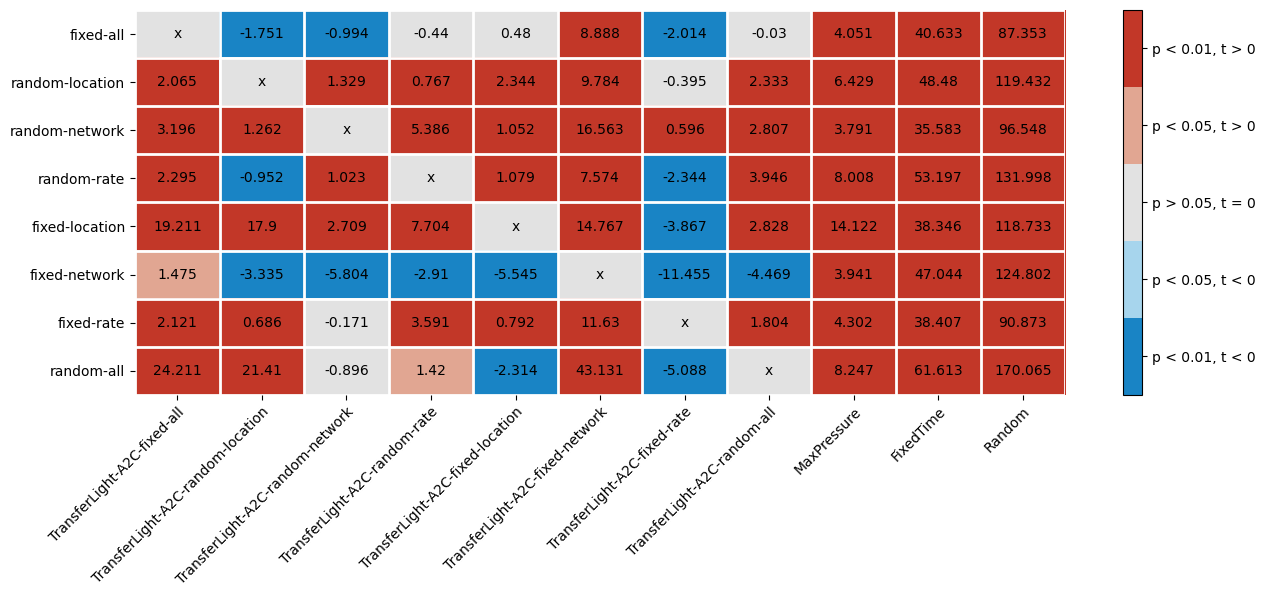

In [104]:
specialized_agents = transferlight_a2c_agents
compare_agents = transferlight_a2c_agents + ["MaxPressure", "FixedTime", "Random"]

test_matrix = paired_t_test_matrix("travel_time", specialized_agents, compare_agents)
plot_paired_t_test_matrix(test_matrix, specialized_agents, compare_agents)

[['x', -2.25, -4.24, -3.212, -1.629, 2.226, 1.004, -3.769, 0.189, 36.686, 83.348], [1.075, 'x', -2.679, -2.086, -0.113, 3.632, 2.834, -2.084, 2.061, 44.023, 114.977], [5.094, 5.565, 'x', 4.182, 1.429, 4.677, -0.559, 0.463, 0.508, 32.297, 93.297], [2.318, 5.971, -3.008, 'x', -0.518, 4.053, 5.132, 1.365, 5.448, 50.59, 129.468], [2.47, 14.708, -3.814, 5.906, 'x', 4.949, -5.835, -2.902, 5.745, 30.338, 112.495], [-2.422, -0.384, -7.784, -4.766, -5.744, 'x', 3.145, -0.477, 2.649, 45.5, 125.097], [7.217, 7.829, 0.575, 5.466, 1.96, 4.541, 'x', 1.296, 2.269, 36.362, 88.964], [-16.281, -4.534, -21.293, -10.083, -16.202, 7.297, -7.155, 'x', -1.277, 42.78, 153.311]]


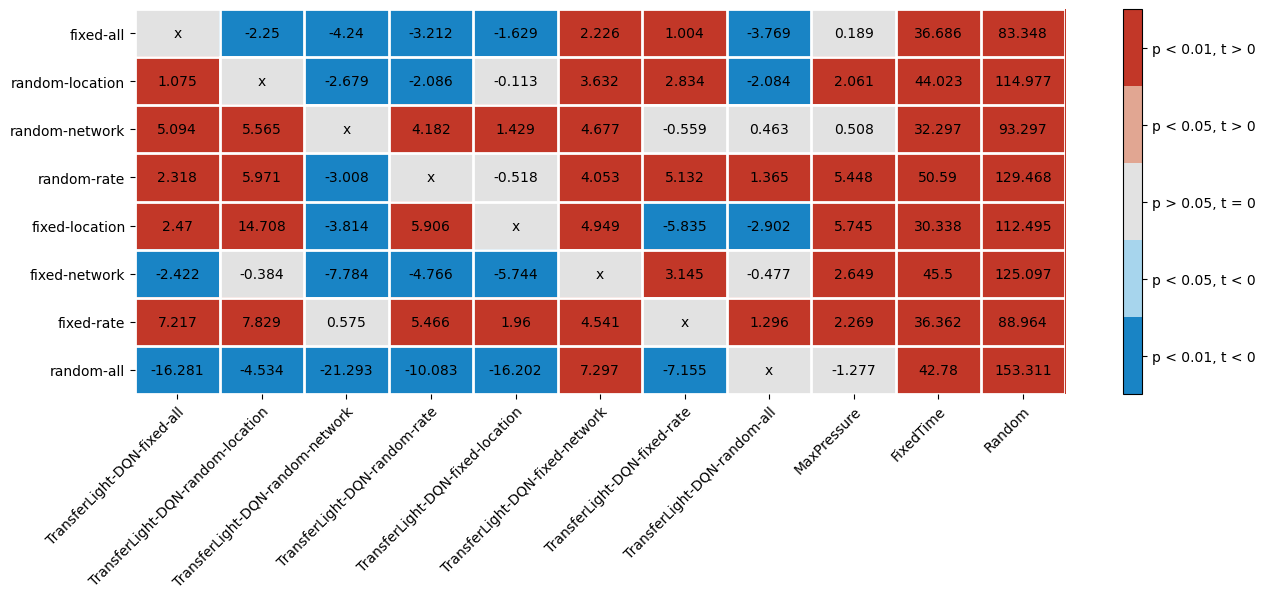

In [105]:
specialized_agents = transferlight_dqn_agents
compare_agents = transferlight_dqn_agents + ["MaxPressure", "FixedTime", "Random"]

test_matrix = paired_t_test_matrix("travel_time", specialized_agents, compare_agents)
plot_paired_t_test_matrix(test_matrix, specialized_agents, compare_agents)

Throughput: 

[['x', 0.7, 0.1, 0.0, -0.7, -2.5, 0.4, 0.0, -0.6, -15.0, -47.0], [-2.0, 'x', -1.7, -1.8, -0.7, -4.6, -0.9, -1.0, -3.3, -18.1, -74.0], [-1.0, -0.2, 'x', -1.5, -0.9, -6.3, 0.0, -1.0, -1.5, -13.7, -72.2], [-1.4, 0.2, -0.4, 'x', -0.4, -5.4, 0.3, -0.7, -2.1, -12.5, -59.1], [-3.5, -1.7, 4.8, 1.5, 'x', 10.1, 4.8, 1.0, -2.4, -12.9, -72.3], [-2.3, 0.4, 1.6, 1.6, -3.2, 'x', -28.3, -4.7, -0.6, -34.8, -131.6], [-0.9, -0.5, -0.4, -0.9, -2.6, -5.0, 'x', -0.8, -1.9, -15.5, -58.4], [-1.4, 0.0, 0.5, -0.6, 0.7, -19.7, 0.7, 'x', -28.4, -4.7, -108.6]]


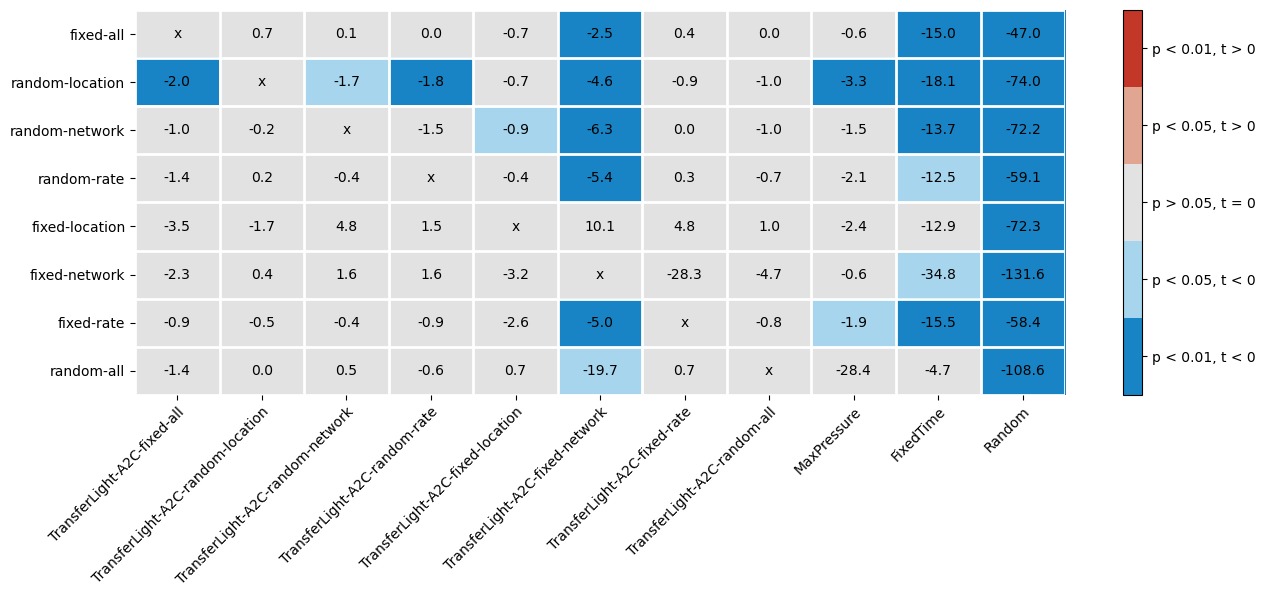

In [106]:
specialized_agents = transferlight_a2c_agents
compare_agents = transferlight_a2c_agents + ["MaxPressure", "FixedTime", "Random"]

test_matrix = paired_t_test_matrix("throughput", specialized_agents, compare_agents)
plot_paired_t_test_matrix(test_matrix, specialized_agents, compare_agents)

In [30]:
def scenario_comparison_stats(group: pd.DataFrame):
    scenario = group["scenario"].unique()[0]
    agents = group["agent"].unique()
    specialized_agent = [agent for agent in agents if agent.endswith(scenario)][0]
    specialized_agent_row = group.query(f'agent == "{specialized_agent}"')
    mu_1 = specialized_agent_row.metric.item()
    s_1 = specialized_agent_row.sd.item()
    n_1 = specialized_agent_row.n.item()
    results = pd.DataFrame()
    for agent in agents:
        agent_row = group.query(f'agent == "{agent}"')
        mu_2 = agent_row.metric.item()
        s_2 = agent_row.sd.item()
        n_2 = agent_row.n.item()
        df = n_1 + n_2 -2
        s_p = (((n_1 - 1) * s_1 ** 2 + (n_2 - 1) * s_2 **2) / df) ** (1/2)
        t_statistic = (mu_2 - mu_1) / ( s_p * (1/n_1 + 1/n_2) ** (1/2) )
        p_value = scipy.stats.t.cdf(-abs(t_statistic), df) * 2
        results[f"{agent}_metric"] = [mu_2]
        results[f"{agent}_t_statistic"] = [t_statistic]
        results[f"{agent}_p_value"] = [p_value]
        results[f"{agent}_df"] = [df]
    return results


def performance_comparison_stats(metric: str, scenarios: List[str], agents: List[str]):
    sort_index = {scenario: rank for scenario, rank in zip(scenarios, range(len(scenarios)))}
    comparison_stats = (
        best_stats
        .query(f'scenario in @scenarios & agent in @agents')
        .loc[:, ["scenario", "agent", metric, f"{metric}_std", f"{metric}_n"]]
        .rename(columns={metric: "metric", f"{metric}_std": "sd", f"{metric}_n": "n"})
        .groupby("scenario")
        .apply(scenario_comparison_stats)
        .reset_index(level=-1, drop=True)
        .reset_index()
        .assign(rank=lambda x: x["scenario"].map(sort_index))
        .sort_values("rank", ascending=True)
        .drop(columns=["rank"])
    )
    distributed_comparison_stats = {"metric": pd.DataFrame(), "t_statistic": pd.DataFrame(), 
                                    "p_value": pd.DataFrame(), "df": pd.DataFrame()}
    for stats_name, results in distributed_comparison_stats.items():
        results["scenario"] = comparison_stats["scenario"]
        for agent in agents:
            results[agent] = comparison_stats[f"{agent}_{stats_name}"] 
    distributed_comparison_stats["metric_name"] = metric
    return distributed_comparison_stats

distributed_comparison_stats = performance_comparison_stats("queue_length", synthetic_scenarios, transferlight_dqn_agents + ["MaxPressure", "FixedTime", "Random"])
distributed_comparison_stats["metric"]

,scenario,TransferLight-DQN-fixed-all,TransferLight-DQN-random-location,TransferLight-DQN-random-network,TransferLight-DQN-random-rate,TransferLight-DQN-fixed-location,TransferLight-DQN-fixed-network,TransferLight-DQN-fixed-rate,TransferLight-DQN-random-all,MaxPressure,FixedTime,Random
0,fixed-all,0.777203,0.720228,0.647555,0.668011,0.751388,0.854972,0.872610,0.655753,0.821526,2.237659,4.341146
5,random-location,0.788785,0.786133,0.680994,0.682521,0.779924,0.874931,0.919358,0.703218,0.868557,2.470262,5.900442
6,random-network,0.968070,1.031215,0.713993,0.975891,0.778272,0.911412,0.704382,0.727500,0.750962,2.223214,6.014717
7,random-rate,1.115649,1.297535,0.937113,1.039558,1.021105,1.165152,1.288640,1.104448,1.255849,2.955138,6.699095
1,fixed-location,4.049109,5.218396,3.443304,4.072363,3.678296,4.200449,3.917142,3.620183,4.093884,5.458443,10.163096
2,fixed-network,1.545670,4.893425,1.344019,2.863046,1.411174,1.589358,4.460021,3.018577,1.726278,3.519206,7.978460
3,fixed-rate,1.022091,1.117761,0.716185,0.944231,0.766233,0.835473,0.708864,0.740356,0.799513,2.315315,5.388877
4,random-all,2.199841,2.934095,1.885467,2.555136,2.119837,3.158517,4.111125,2.813325,4.831615,4.757337,13.156354


In [35]:
def performance_comparison_heatmap(comparison_stats: Dict[str, pd.DataFrame]):
    fig, ax = plt.subplots(figsize=(15, 5))
    scenarios = comparison_stats["metric"]["scenario"].tolist()
    agents = comparison_stats["metric"].drop(columns=["scenario"]).columns.tolist()
    metric_name = comparison_stats["metric_name"]
    metric_data = np.round(comparison_stats["metric"].drop("scenario", axis=1).to_numpy(), decimals=3)
    t_statistic_data = comparison_stats["t_statistic"].drop("scenario", axis=1).to_numpy()
    p_value_data = comparison_stats["p_value"].drop("scenario", axis=1).to_numpy()
    significance_lvl = (p_value_data <= 0.05).astype(int) + (p_value_data <= 0.01).astype(int)
    
    data = np.sign(t_statistic_data) * significance_lvl
    
    cmap = ListedColormap(["#1984c5", "#a7d5ed", "#e2e2e2", "#e1a692", "#c23728"])
    im = ax.imshow(data, cmap=cmap, vmin=-2, vmax=2, aspect='auto')
    colorbar = ax.figure.colorbar(im, ax=ax)
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks([colorbar.vmin + r / 5 * (0.5 + i) for i in range(5)])
    colorbar.set_ticklabels(["p < 0.01, t < 0", "p < 0.05, t < 0", "p > 0.05, t = 0", "p < 0.05, t > 0", "p < 0.01, t > 0"])  
    ax.spines[:].set_visible(False)
    ax.set_xticks(np.arange(len(agents)), labels=agents)
    ax.set_yticks(np.arange(len(scenarios)), labels=scenarios)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    
    for r in range(len(scenarios)):
        for c in range(len(agents)):
            _ = ax.text(c, r, metric_data[r, c], ha="center", va="center")
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle="-", linewidth=2)
    ax.tick_params(which="minor", bottom=False, left=False)

### Throughput

A2C:

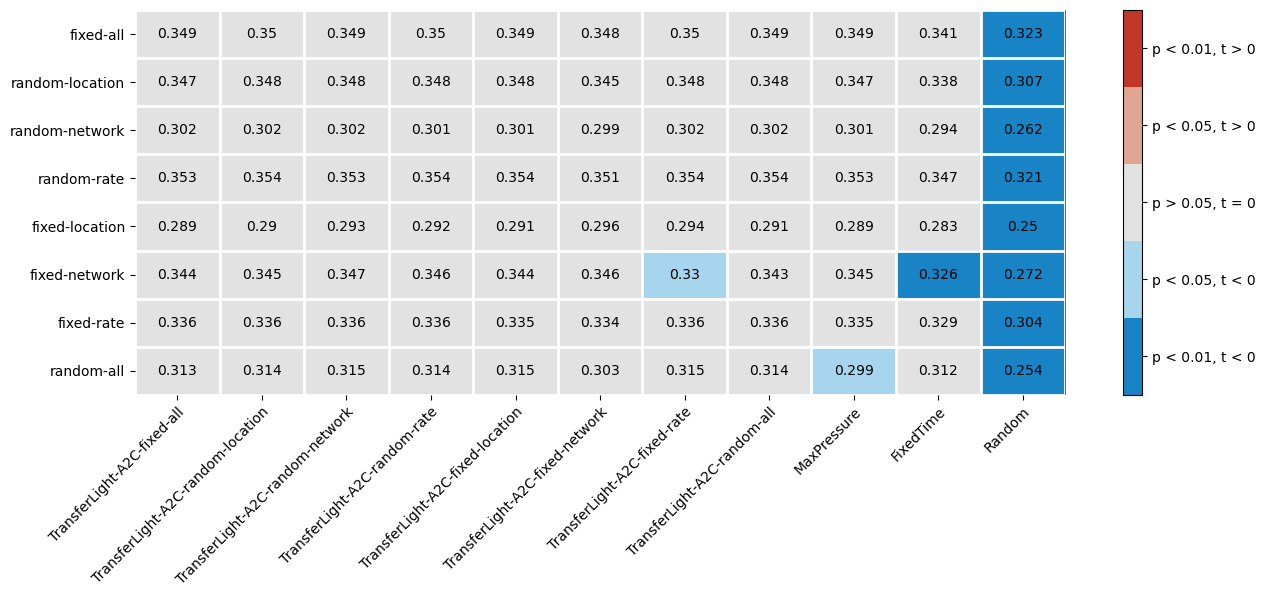

In [39]:
performance_comparison_heatmap(performance_comparison_stats("throughput", synthetic_scenarios, transferlight_a2c_agents + ["MaxPressure", "FixedTime", "Random"]))

DQN:

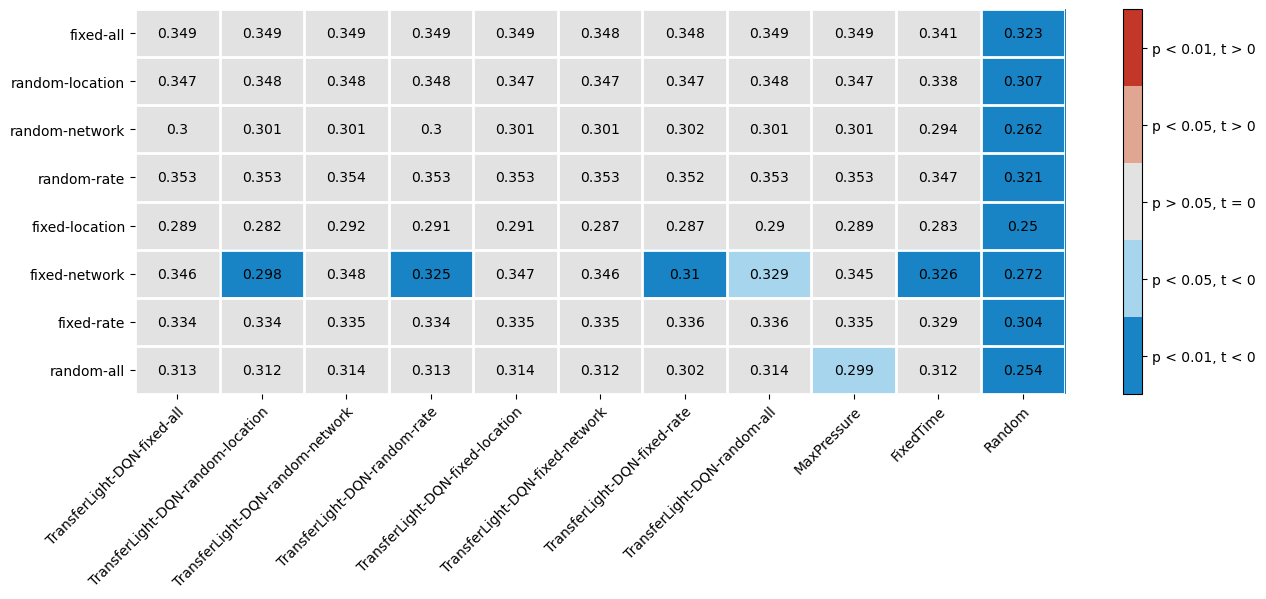

In [41]:
performance_comparison_heatmap(performance_comparison_stats("throughput", synthetic_scenarios, transferlight_dqn_agents + ["MaxPressure", "FixedTime", "Random"]))

### Travel Time

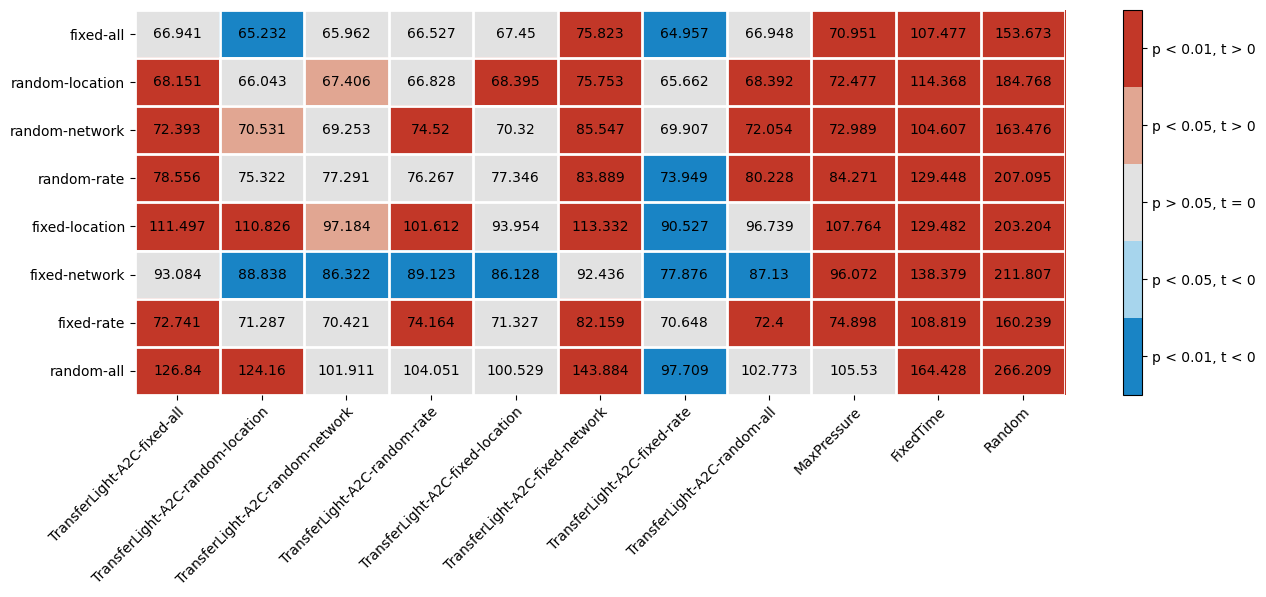

In [37]:
performance_comparison_heatmap(performance_comparison_stats("travel_time", synthetic_scenarios, transferlight_a2c_agents + ["MaxPressure", "FixedTime", "Random"]))

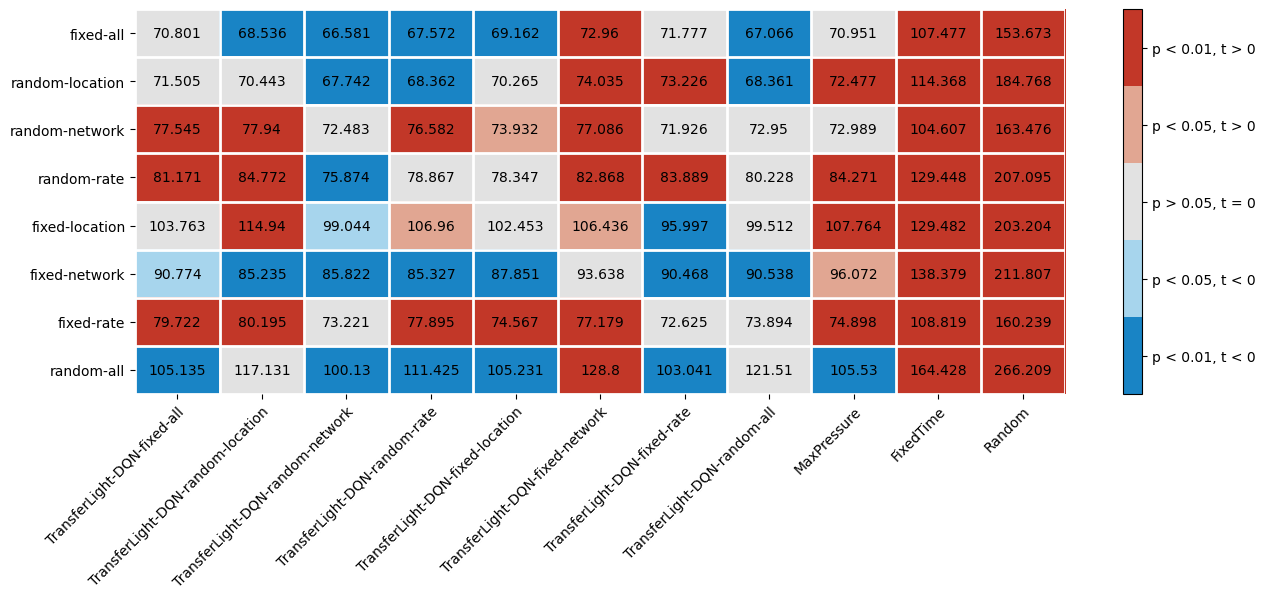

In [38]:
performance_comparison_heatmap(performance_comparison_stats("travel_time", synthetic_scenarios, transferlight_dqn_agents + ["MaxPressure", "FixedTime", "Random"]))

### Queue Length

DQN:

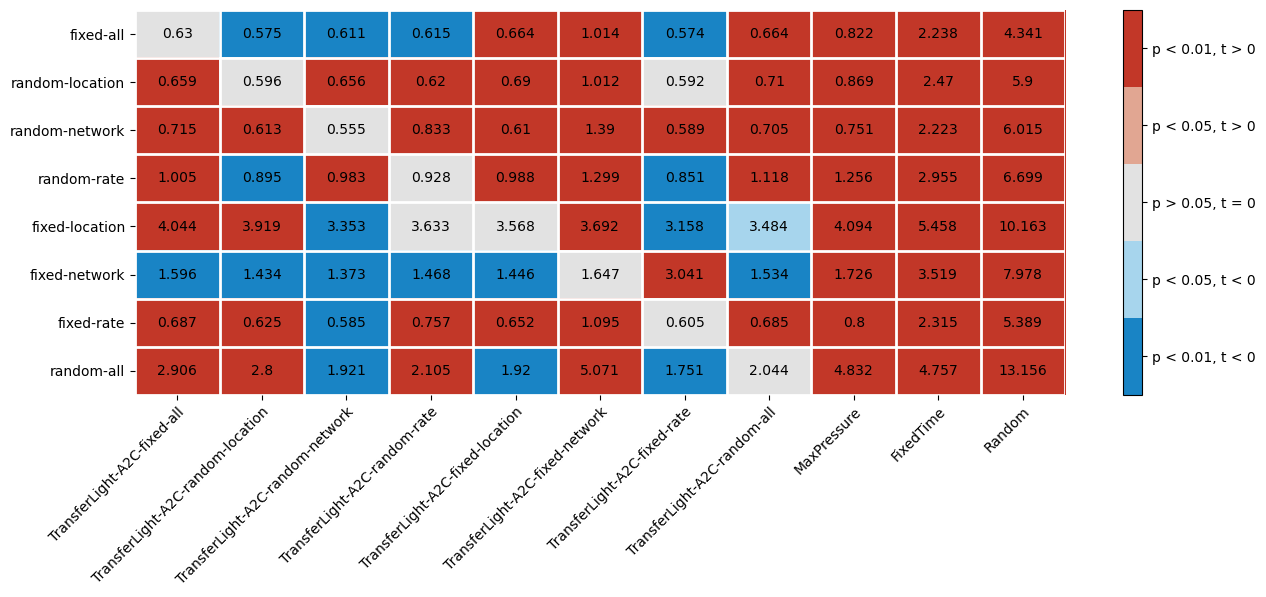

In [36]:
performance_comparison_heatmap(performance_comparison_stats("queue_length", synthetic_scenarios, transferlight_a2c_agents + ["MaxPressure", "FixedTime", "Random"]))

A2C: 

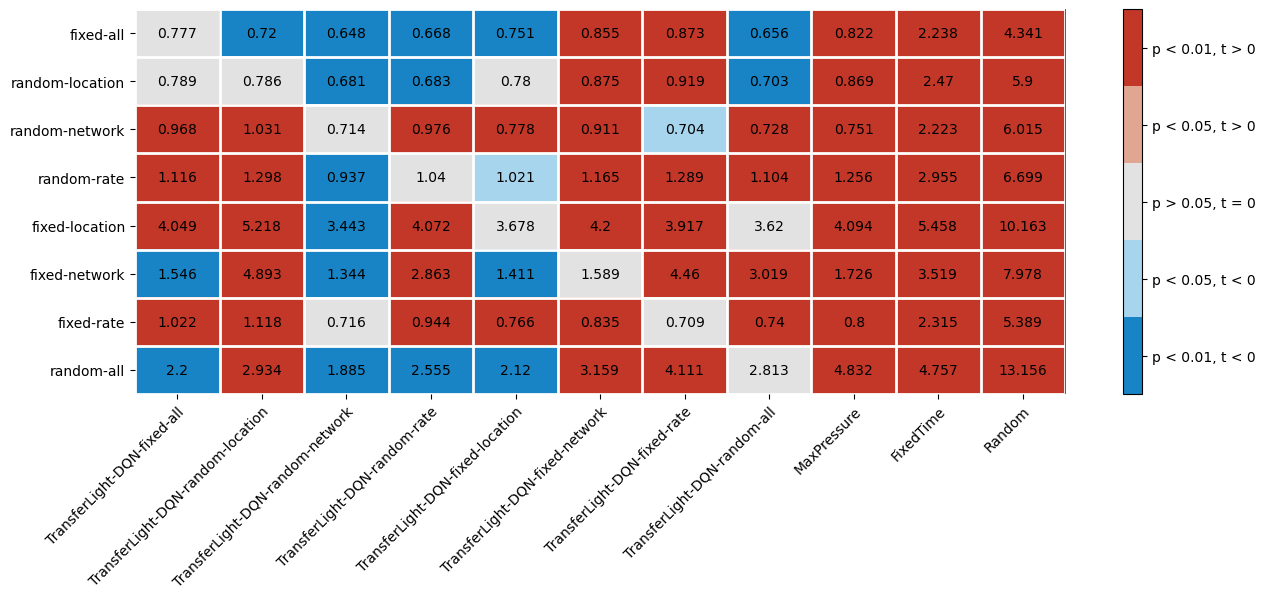

In [34]:
performance_comparison_heatmap(performance_comparison_stats("queue_length", synthetic_scenarios, transferlight_dqn_agents + ["MaxPressure", "FixedTime", "Random"]))

### Waiting Time: 

A2C:

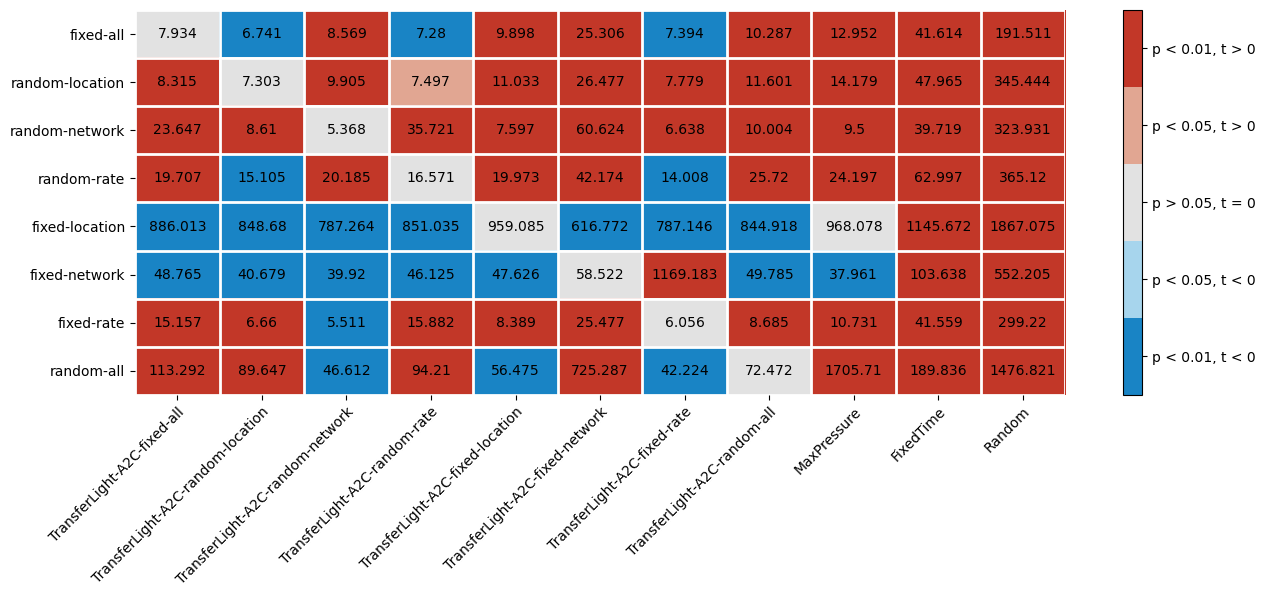

In [42]:
performance_comparison_heatmap(performance_comparison_stats("waiting_time", synthetic_scenarios, transferlight_a2c_agents + ["MaxPressure", "FixedTime", "Random"]))

DQN

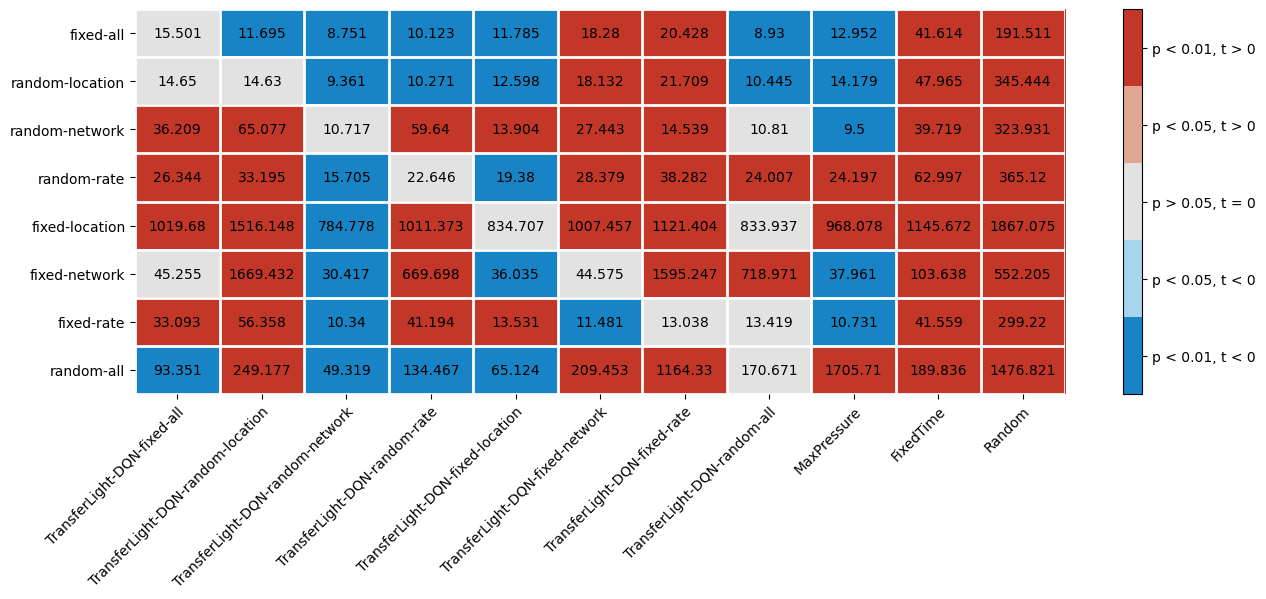

In [43]:
performance_comparison_heatmap(performance_comparison_stats("waiting_time", synthetic_scenarios, transferlight_dqn_agents + ["MaxPressure", "FixedTime", "Random"]))

### Arterial Road Network 